## Titanic dataset - EDA, Feature selection/engineering

* **Type:** Binary classification
* **Framework:** sklearn
* **Goals:**
    - get familiar with the dataset
    - explore the features

## 1. Initial checks
- number of features, exaples in training/testing datasets
- explanation of the features, their datatypes

In [163]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import seaborn as sns
from matplotlib import pyplot as plt
import re
import plotly.graph_objs as go
import plotly.plotly as ply
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [164]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [165]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

* survival - Survival - 0 = No, 1 = Yes
* pclass - Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
* sex - Sex	
* Age - Age in years	
* sibsp - # of siblings / spouses aboard the Titanic	
* parch - # of parents / children aboard the Titanic	
* ticket - Ticket number	
* fare - Passenger fare	
* cabin - Cabin number	
* embarked - Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton

In [166]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Types of features
* categorical: `Survived` (target), `sex`, `Embarked`
* ordinal: `pclass`
* numerical: `age`, `fare` (continuous), `SibSp`, `Parch` (discrete)

* errors/typos?: `name`
* NaNs?: `Cabin`

## 2. EDA

### goals:
- How representative is the training dataset of the actual problem? How does it compare to testing dataset? - check means and variances + compare
- check NaN values - how many are there, are the features worth keeping? how to impute them?
- check out the distribution of some features
- check NaN values
- check correlations among features

In [167]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Goodwin, Master. William Frederick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [168]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Herman, Miss. Kate",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [169]:
def count_nans(df, features):
    for feature in features:
        print(f"{feature}: {len(df[df[feature].isna() == True])}")
count_nans(train_df, train_df.columns.values)
print("--")
count_nans(test_df, test_df.columns.values)

PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2
--
PassengerId: 0
Pclass: 0
Name: 0
Sex: 0
Age: 86
SibSp: 0
Parch: 0
Ticket: 0
Fare: 1
Cabin: 327
Embarked: 0


`cabin` and `age` contain a lot of null values, might be potentially dropped if they're not correlated with `Survival`

**Insights from the distributions:** Most passengers were 2nd class and higher (`pclass`), the mean `age` is relatively low, indicating there were few elderly passengers,  there is a big variance in `Fare`s, some passengers payed as much as 512$ with the average being 35. All `Name`s are unique and there are 2 categories for sex and 3 for embarked.

In [170]:
print(f"Size of training: {len(train_df.values)} and testing: {len(test_df.values)} sets")
print(f"How many passengers are travelling with no family: {len(train_df.loc[(train_df['SibSp'] == 0) & (train_df['Parch'] == 0)])}")

Size of training: 891 and testing: 418 sets
How many passengers are travelling with no family: 537


In [171]:
def value_counts(df, features):
    for feature in features:
        print(df[feature].value_counts())
        
value_counts(train_df, ["Sex", "Survived"])
value_counts(test_df, ["Sex"])

male      577
female    314
Name: Sex, dtype: int64
0    549
1    342
Name: Survived, dtype: int64
male      266
female    152
Name: Sex, dtype: int64


In [172]:
print(f"Unique values for 'Name': {train_df['Name'].nunique()}")
print(f"Unique values for 'Sex': {train_df['Sex'].nunique()}")

Unique values for 'Name': 891
Unique values for 'Sex': 2


## 3. Feature selection and engineering
- encode categoricals with string literals
- handle NaN values
- check distributions and correlation matrix of the features
- check specifically correlation with the target variable

In [173]:
def encode_categoricals(df, features_to_encode):
    encoded_df = df.copy()
    for feature in features_to_encode:
        c = 0
        encode_dict = {}
        for feature_value in list(df[feature].unique()):
            encode_dict[feature_value] = c
            c+=1
        encoded_df[feature] = encoded_df[feature].map(encode_dict)
    return encoded_df

def drop_nans(df, features):
    for feature in features:
        df[feature + "_dropped"] = df[feature].dropna()

def fill_nans_with_median(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(df[feature].median())

encoded_train_df = encode_categoricals(train_df, ["Sex", "Ticket", "Embarked", "Cabin", "Age"])
encoded_test_df = encode_categoricals(test_df, ["Sex", "Ticket", "Embarked", "Cabin", "Age"])
fill_nans_with_median(encoded_train_df, ["Age", "Cabin", "Embarked", "Fare"])
fill_nans_with_median(encoded_test_df, ["Age", "Cabin", "Embarked", "Fare"])

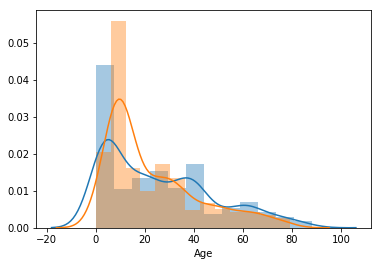

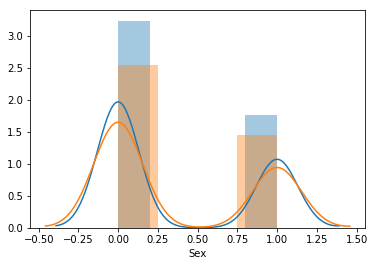

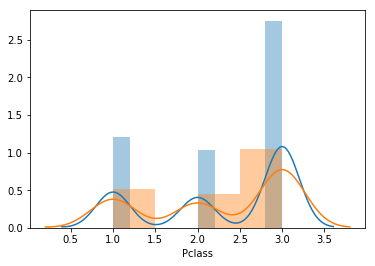

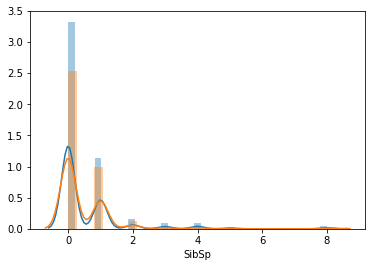

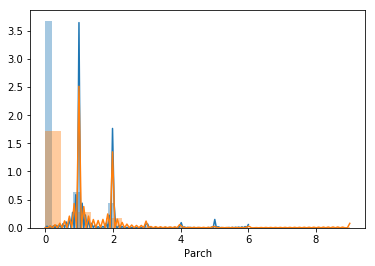

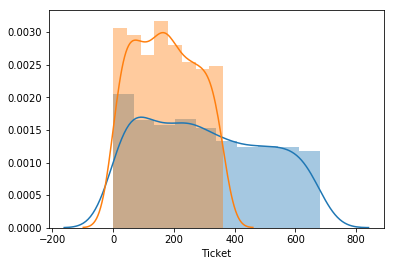

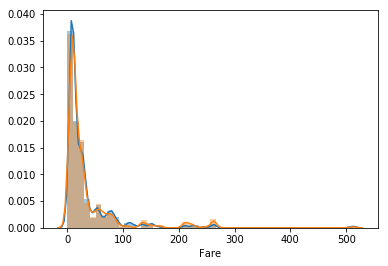

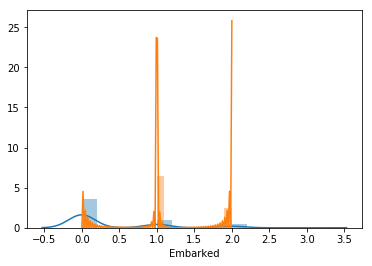

In [174]:
def plot_distributions(train_dataset, test_dataset, features):
    for feature in features:
        sns.distplot(train_dataset[feature].dropna())
        if test_dataset is not None:
            sns.distplot(test_dataset[feature].dropna())
        plt.show()
plot_distributions(encoded_train_df, encoded_test_df, ["Age", "Sex", "Pclass", "SibSp", "Parch", "Ticket", "Fare", "Embarked"])

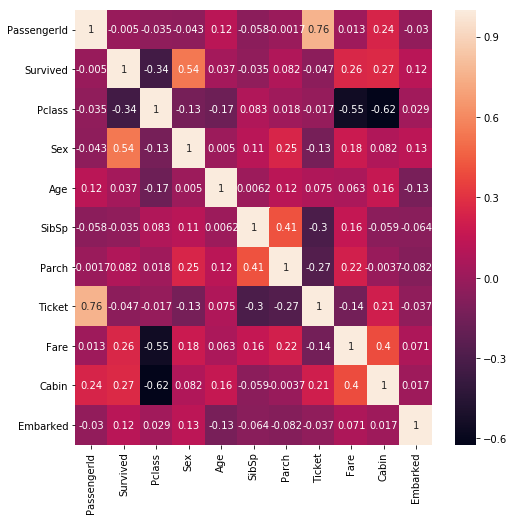

In [175]:
plt.figure(figsize=(8, 8))
corr = encoded_train_df.corr()
sns.heatmap(corr, annot=True)

Explore the correlations in more detail and try to come up with new features - check how they're correlated with `Survived`.

In [176]:
for encoded_df in [encoded_train_df, encoded_test_df]:
    encoded_df['family_size'] = encoded_df['SibSp'] + encoded_df['Parch'] + 1
    encoded_df['is_alone'] = np.where(encoded_df['family_size'] == 1, 1, 0)
    encoded_df['category_fare'] = pd.qcut(encoded_df['Fare'], 4)
    encoded_df['category_age'] = pd.qcut(encoded_df['Age'], 4)

print(encoded_train_df[["Pclass","Survived"]].groupby(["Pclass"], as_index = False).mean())
print(encoded_train_df[["Sex","Survived"]].groupby(["Sex"], as_index = False).mean())
print(encoded_train_df[["Embarked","Survived"]].groupby(["Embarked"], as_index = False).mean())

print(encoded_train_df[["family_size","Survived"]].groupby(["family_size"], as_index = False).mean())
print(encoded_train_df[["is_alone","Survived"]].groupby(["is_alone"], as_index = False).mean())
print(encoded_train_df[["category_fare","Survived"]].groupby(["category_fare"], as_index = False).mean().sort_values(by='category_fare', ascending=True))
print(encoded_train_df[["category_age","Survived"]].groupby(["category_age"], as_index = False).mean().sort_values(by='category_age', ascending=True))

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
   Sex  Survived
0    0  0.188908
1    1  0.742038
   Embarked  Survived
0         0  0.336957
1         1  0.553571
2         2  0.389610
3         3  1.000000
   family_size  Survived
0            1  0.303538
1            2  0.552795
2            3  0.578431
3            4  0.724138
4            5  0.200000
5            6  0.136364
6            7  0.333333
7            8  0.000000
8           11  0.000000
   is_alone  Survived
0         0  0.505650
1         1  0.303538
     category_fare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081
    category_age  Survived
0  (-0.001, 4.0]  0.338645
1    (4.0, 22.0]  0.422330
2   (22.0, 40.0]  0.390135
3   (40.0, 88.0]  0.393365


Let's handle `Name`, there are occasional titles that might indicate some correlation too, let's extract

In [177]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

encoded_train_df['title'] = encoded_train_df['Name'].apply(get_title)
encoded_test_df['title'] = encoded_test_df['Name'].apply(get_title)

for data in [encoded_train_df, encoded_test_df]:
    data['title'] = data['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
    data['title'] = data['title'].replace('Mlle','Miss')
    data['title'] = data['title'].replace('Ms','Miss')
    data['title'] = data['title'].replace('Mme','Mrs')
    
encoded_train_df = encode_categoricals(encoded_train_df, ['title'])
encoded_train_df['title'] = encoded_train_df['title'].fillna(0)

encoded_test_df = encode_categoricals(encoded_test_df, ['title'])
encoded_test_df['title'] = encoded_test_df['title'].fillna(0)

print(encoded_train_df[['title','Survived']].groupby(['title'], as_index = False).mean())

   title  Survived
0      0  0.156673
1      1  0.793651
2      2  0.702703
3      3  0.575000
4      4  0.347826


### 4. Final cleanup

In [178]:
for data in [encoded_train_df, encoded_test_df]:
    #Mapping Fare
    data.loc[ data['Fare'] <= 7.91, 'Fare']                            = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
    data.loc[ data['Fare'] > 31, 'Fare']                               = 3
    data['Fare'] = data['Fare'].astype(int)

    #Mapping Age
    data.loc[ data['Age'] <= 16, 'Age']                       = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age']    

## 5. Baseline results
- train a simple decision tree

In [180]:
drop_elements = ["Name", "Ticket", "Cabin", "SibSp", "Parch", "family_size", "category_fare", "category_age"]
encoded_train_df = encoded_train_df.drop(drop_elements, axis = 1)
encoded_train_df = encoded_train_df.drop(['PassengerId'], axis = 1)
encoded_test_df = encoded_test_df.drop(drop_elements, axis = 1)

X_train = encoded_train_df.drop("Survived", axis=1)
Y_train = encoded_train_df["Survived"]
X_test  = encoded_test_df.drop("PassengerId", axis=1).copy()

In [181]:
encoded_test_df

,PassengerId,Pclass,Sex,Age,Fare,Embarked,is_alone,title
0,892,3,0,0,0,0,1,0
1,893,3,1,0,0,1,0,1
2,894,2,0,0,1,0,1,0
3,895,3,0,0,1,1,1,0
4,896,3,1,0,1,1,0,1
5,897,3,0,0,1,1,1,0
6,898,3,1,0,0,0,1,2
7,899,2,0,0,2,1,0,0
8,900,3,1,0,0,2,1,1
9,901,3,0,0,2,1,0,0


In [182]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
accuracy = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  88.22


In [183]:
submission = pd.DataFrame({
    "PassengerId": encoded_test_df["PassengerId"],
    "Survived": Y_pred
})
submission.to_csv('submission.csv', index = False)